In [1]:
# Import necessary libraries
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
def load_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    # Create DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [3]:
# Change label names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung_squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

data_dir = './lung_image_sets'
df = load_data(data_dir)
change_label_names(df, 'labels')


In [4]:
# Split data into train, validation, and test sets
train_df, ts_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)

batch_size = 32
img_size = (224, 224)

# Data generators
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', shuffle=False, batch_size=batch_size)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [5]:
# Model creation using ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Create a sequential model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)


In [6]:
# Train the model
epochs = 5
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[early_stop, reduce_lr])


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 943s 2s/step - accuracy: 0.7177 - loss: 0.6408 - val_accuracy: 0.6547 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 915s 2s/step - accuracy: 0.8268 - loss: 0.4072 - val_accuracy: 0.8653 - val_loss: 0.3358 - learning_rate: 0.0010
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 916s 2s/step - accuracy: 0.8430 - loss: 0.3731 - val_accuracy: 0.8760 - val_loss: 0.3119 - learning_rate: 0.0010
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 904s 2s/step - accuracy: 0.8465 - loss: 0.3647 - val_accuracy: 0.8780 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - accuracy: 0.8578 - loss: 0.3356 - val_accuracy: 0.8973 - val_loss: 0.2813 - learning_rate: 0.0010


In [7]:
# Model Performance Plotting
def model_performance(history, epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    Epochs = [i+1 for i in range(len(tr_acc))]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

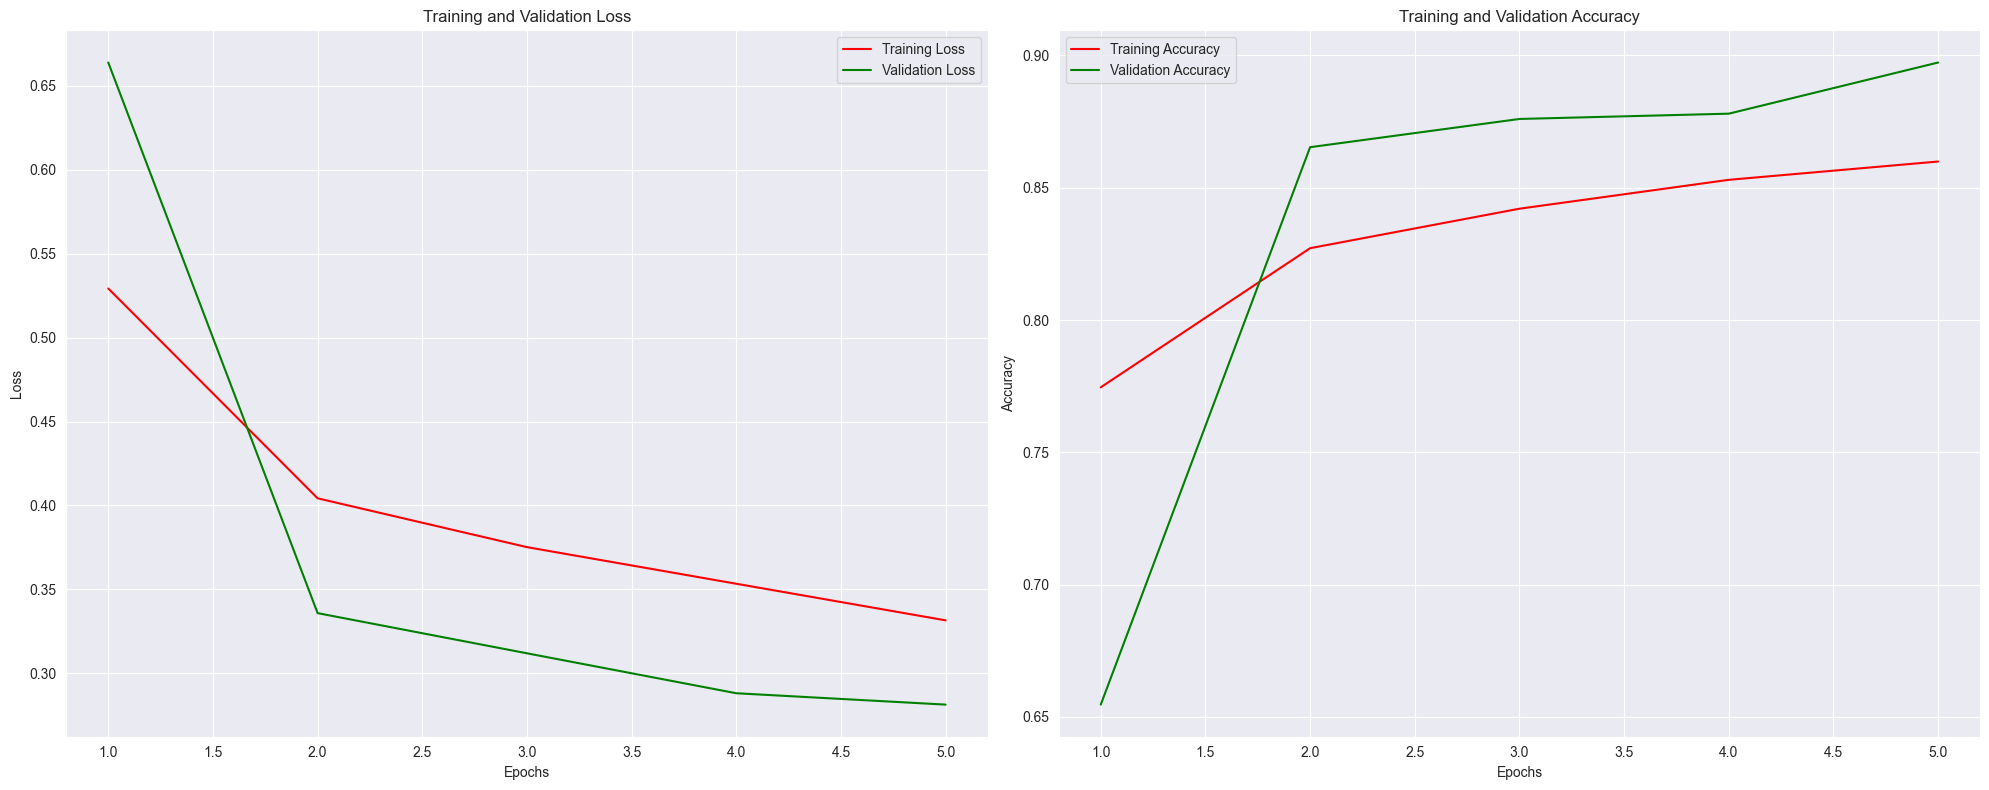

In [8]:
# Call the function with history object and number of epochs
epochs = len(history.history['accuracy'])  # Number of epochs based on history
model_performance(history, epochs)

In [9]:
# Model Evaluation
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose=1)
    valid_score = model.evaluate(valid_gen, verbose=1)
    test_score = model.evaluate(test_gen, verbose=1)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [10]:
model_evaluation(model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9041 - loss: 0.2440
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8775 - loss: 0.3096
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8705 - loss: 0.3196
Train Loss:  0.24463783204555511
Train Accuracy:  0.9054999947547913
--------------------
Validation Loss:  0.2813411056995392
Validation Accuracy:  0.8973333239555359
--------------------
Test Loss:  0.30008479952812195
Test Accuracy:  0.8766666650772095


In [11]:
# Get Predictions
def get_pred(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    return y_pred

In [12]:

# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    cm = confusion_matrix(test_gen.classes, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step


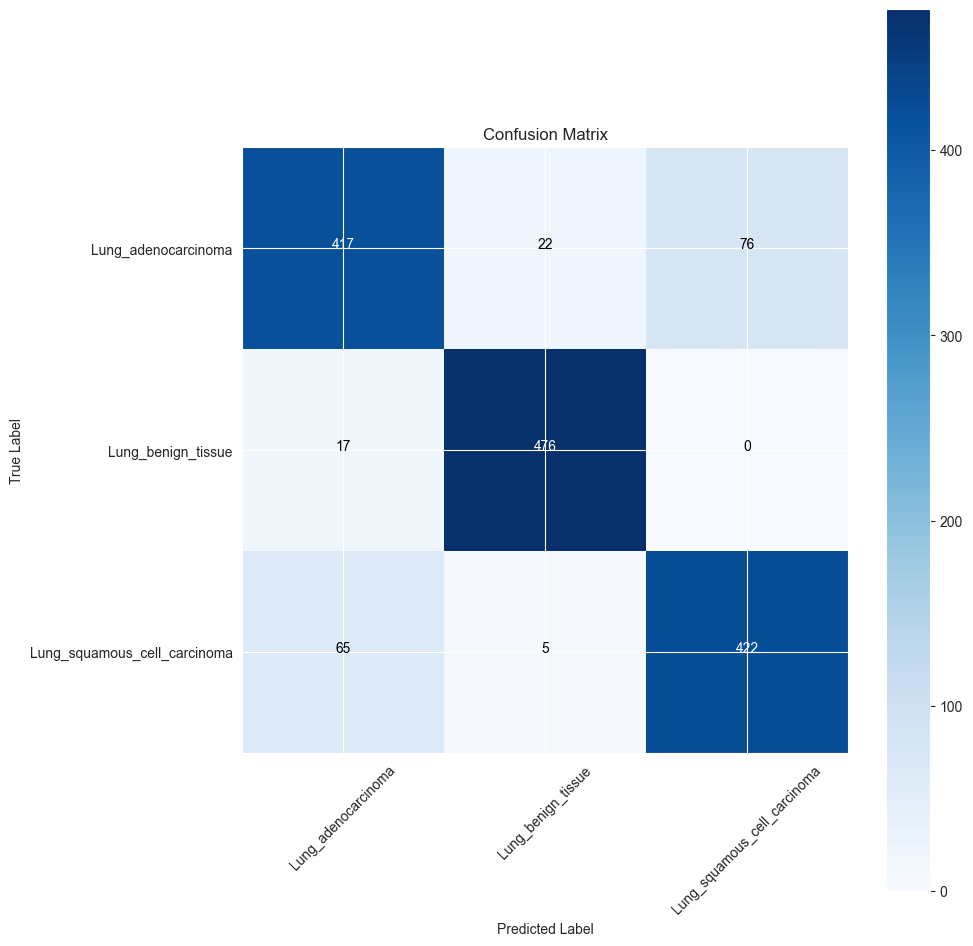

In [13]:
# Call the get_pred function to make predictions
y_pred = get_pred(model, test_gen)

# Call the plot_confusion_matrix function to plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

375/375 ━━━━━━━━━━━━━━━━━━━━ 590s 2s/step


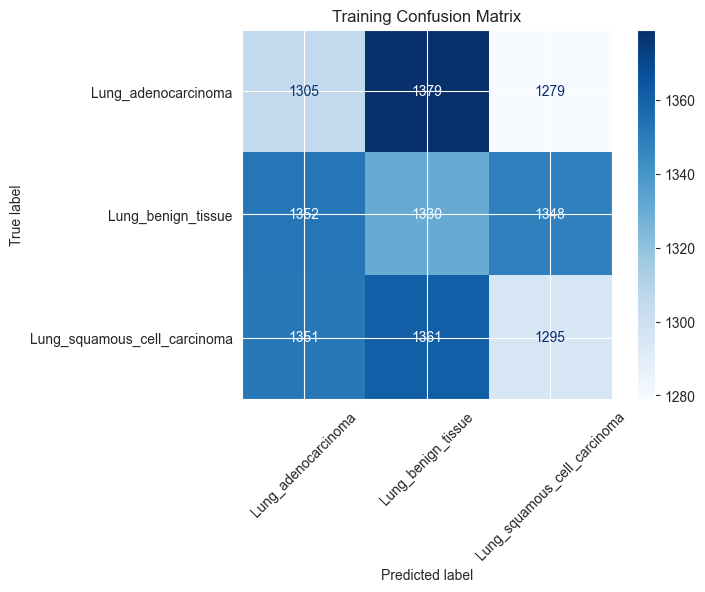

375/375 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step


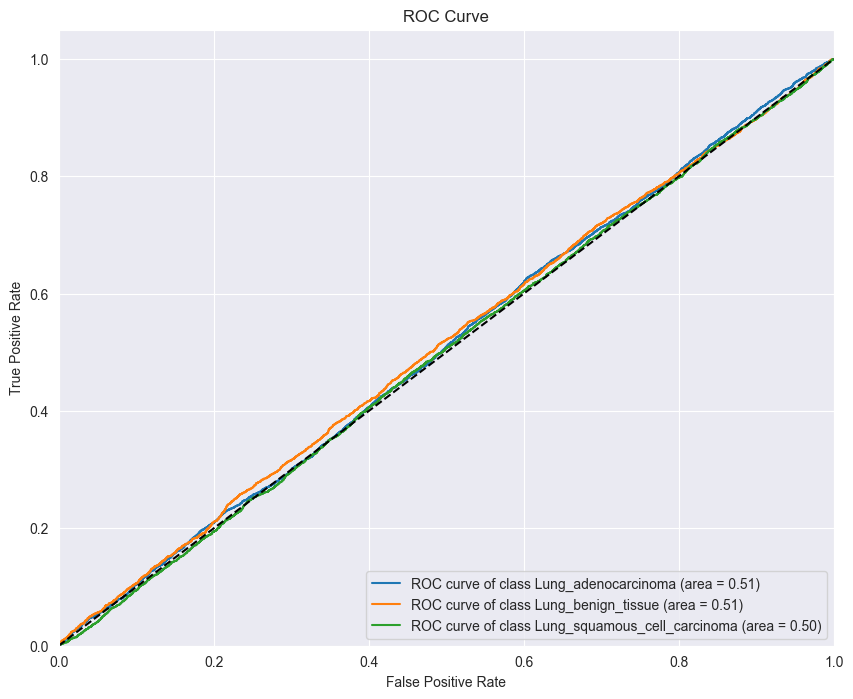

In [14]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the training set
y_train_pred = get_pred(model, train_gen)

# True labels from the training generator
y_train_true = train_gen.classes

# Plot the training confusion matrix
def plot_training_confusion_matrix(train_gen, y_train_pred):
    # Get class names
    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_train_true, y_train_pred)
    
    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Training Confusion Matrix")
    plt.show()

# Call the function to plot the training confusion matrix
plot_training_confusion_matrix(train_gen, y_train_pred)


# ROC Curve Plotting Function
def plot_roc_curve(train_gen, model, data_gen):
    g_dict = train_gen.class_indices
    classes = list(g_dict.keys())
    
    # Binarize the output
    y_true = label_binarize(train_gen.classes, classes=[0, 1, 2])  # Assuming 3 classes: Normal, SCC, Adenocarcinoma
    
    # Get predictions (probabilities)
    y_score = model.predict(data_gen)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Plot the ROC curve
plot_roc_curve(train_gen, model, train_gen)
